In [1]:
import pandas as pd

file_data = "Mall_Customers_no_CustomerID.csv"

df = pd.read_csv(file_data)

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [2]:
df_analise = df.copy()
df_analise.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(
    [
        ('standard', StandardScaler(), ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']),
        ('onehot', OneHotEncoder(), ['Gender']),
    ]
)

df_onescaled = pd.DataFrame(
    preprocessing.fit_transform(df_analise),
    columns = preprocessing.get_feature_names_out(),
)

df_onescaled.head()

,standard__Age,standard__Annual Income (k$),standard__Spending Score (1-100),onehot__Gender_Female,onehot__Gender_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0


In [5]:
# import joblib

# joblib.dump(
#     preprocessing,
#     'preprocessing.pkl'
#     )

['/content/drive/MyDrive/segmentacao_cliente/models/preprocessing.pkl']

In [ ]:
df_onescaled.to_csv('Mall_Customers_no_CustomerID_preprocessing.csv', index=False)

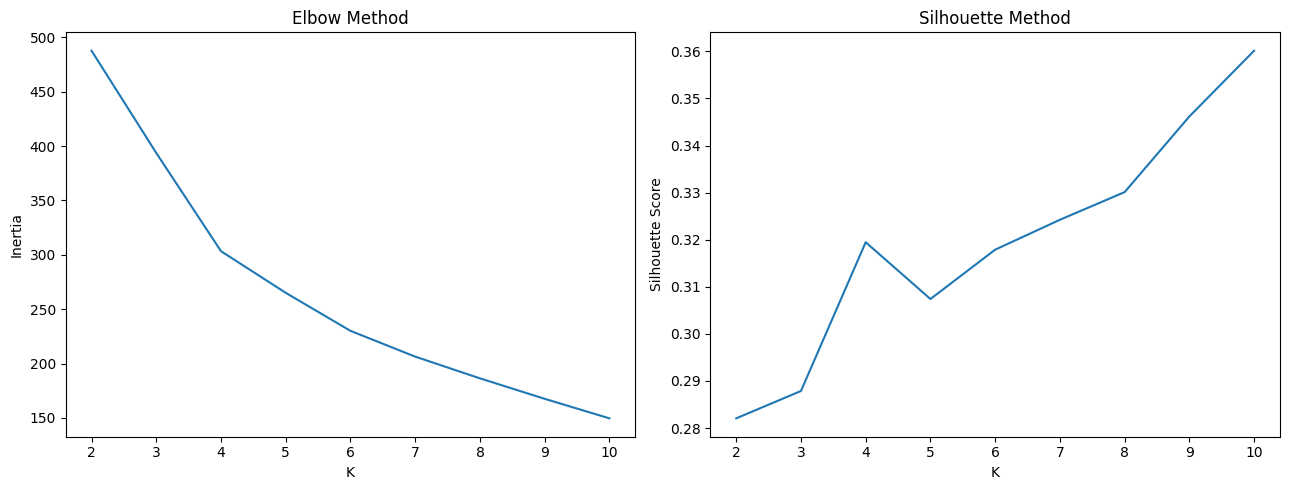

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def grafico_elbow_silhouette(
    X, random_state=42, intervalo=(2, 11)
):

  elbow = {}
  silhouette = []

  k_range = range(*intervalo)


  for i in k_range:
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=random_state)
    kmeans.fit(X)
    elbow[i] = kmeans.inertia_

    labels = kmeans.labels_
    silhouette.append(silhouette_score(X, labels))

  fig, axs = plt.subplots(ncols=2, figsize=(13,5), tight_layout=True)


  sns.lineplot(x=list(elbow.keys()), y=list(elbow.values()), ax=axs[0])
  axs[0].set_xlabel('K')
  axs[0].set_ylabel('Inertia')
  axs[0].set_title('Elbow Method')

  sns.lineplot(x=list(k_range), y=silhouette, ax=axs[1])
  axs[1].set_xlabel('K')
  axs[1].set_ylabel('Silhouette Score')
  axs[1].set_title('Silhouette Method')

  plt.show()

grafico_elbow_silhouette(df_onescaled)

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
RANDOM_STATE = 42

clustered = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
clustered.fit(df_onescaled)

df_analise['clusters'] = clustered.labels_
df_onescaled['clusters'] = clustered.labels_

In [8]:
# joblib.dump(
#     clustered,
#     'kmeans.pkl'
# )

['/content/drive/MyDrive/segmentacao_cliente/models/kmeans.pkl']

In [ ]:
df_analise.clusters.value_counts(normalize=True).mul(100).sort_index()

0    32.5
1    28.5
2    19.0
3    20.0
Name: clusters, dtype: float64

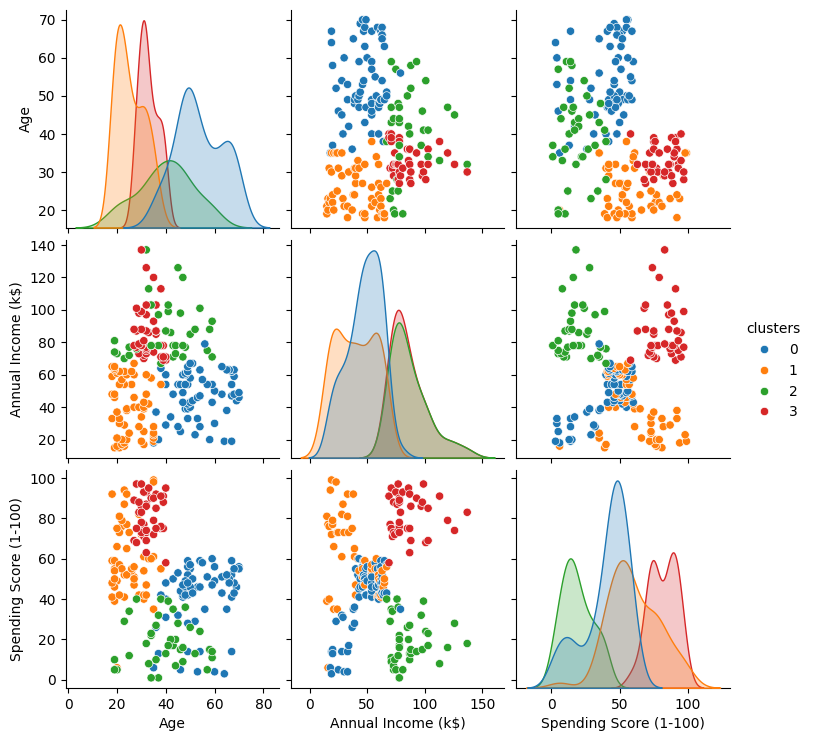

In [ ]:
sns.pairplot(df_analise, diag_kind='kde', hue='clusters', palette='tab10');

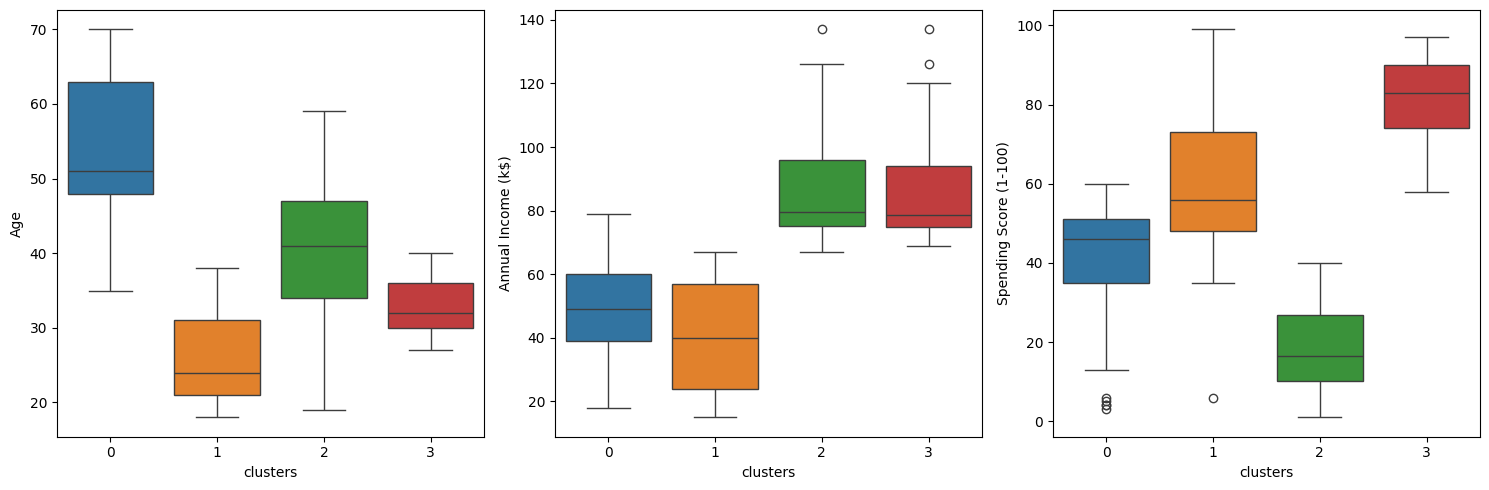

In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5), tight_layout=True)

for ax, col in zip(axs, df_analise.select_dtypes('number')):
  sns.boxplot(
      data=df_analise, x='clusters', y=col, ax=ax,
      hue='clusters',palette='tab10', legend=False
    )

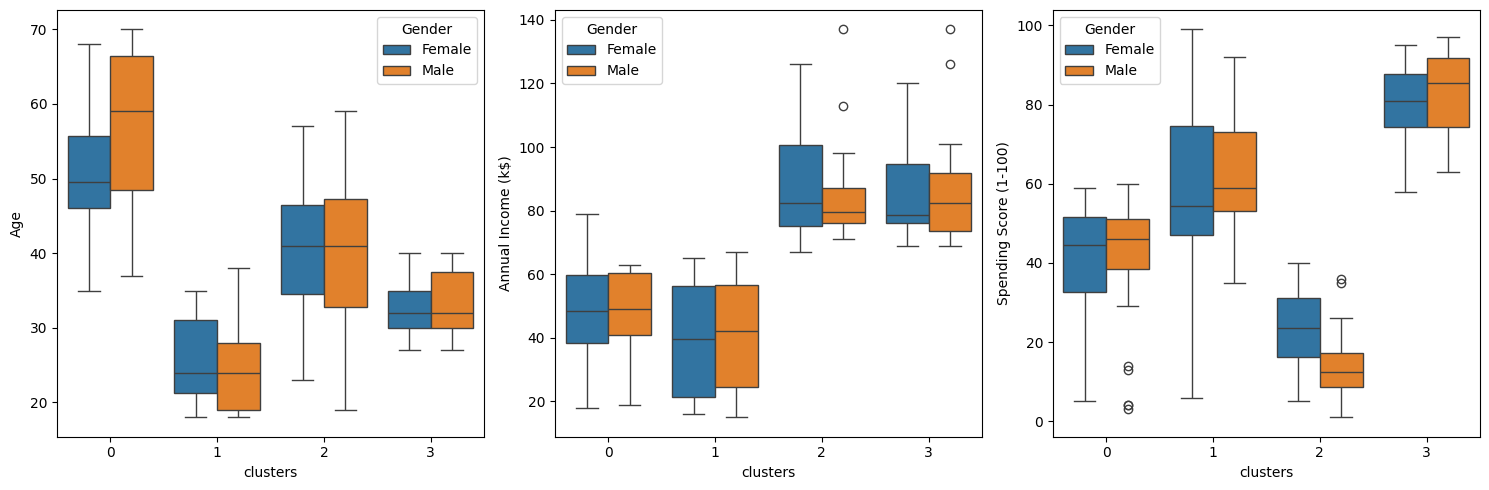

In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5), tight_layout=True)

for ax, col in zip(axs, df_analise.select_dtypes('number')):
  sns.boxplot(
      data=df_analise, x='clusters', y=col, ax=ax,
      hue='Gender'
    )

In [ ]:
df_analise.groupby(by=['clusters', 'Gender']).size()

clusters  Gender
0         Female    38
          Male      27
1         Female    34
          Male      23
2         Female    18
          Male      20
3         Female    22
          Male      18
dtype: int64

In [ ]:
centroids = clustered.cluster_centers_[:, :-2]
centroids

array([[ 1.06297508, -0.4946758 , -0.37865953],
       [-0.96249203, -0.78476346,  0.39202966],
       [ 0.0768659 ,  0.9971462 , -1.22042727],
       [-0.42880597,  0.97484722,  1.21608539]])

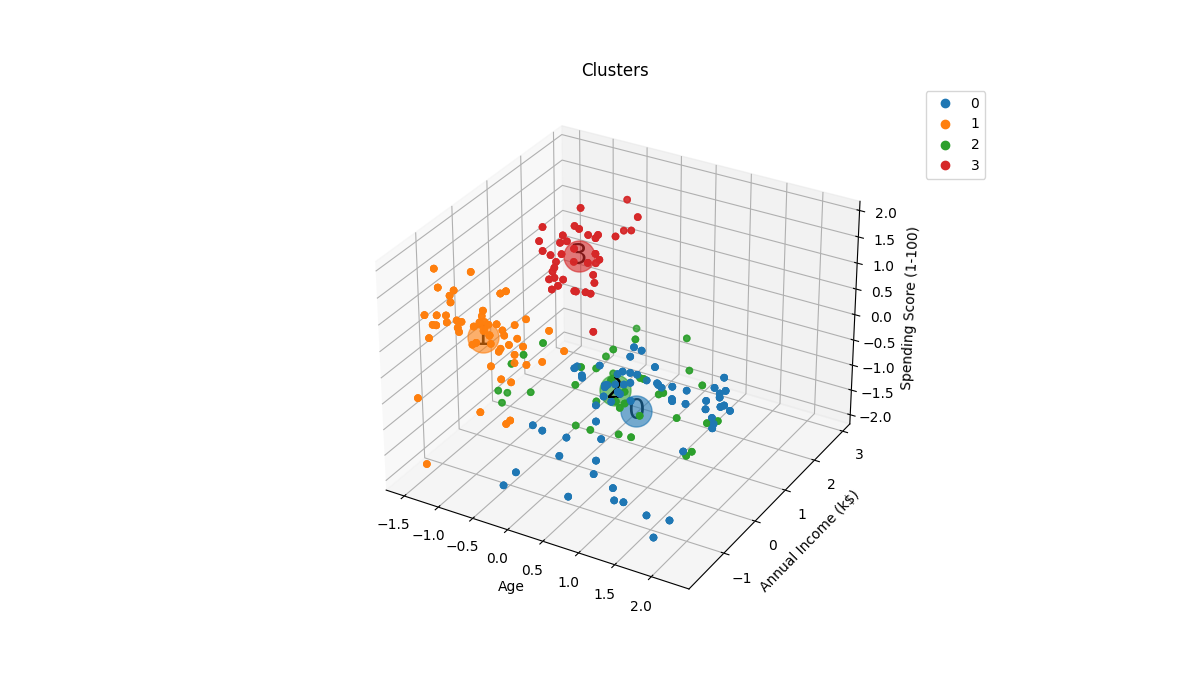

In [ ]:
%matplotlib ipympl
from matplotlib.colors import ListedColormap

def visualizar_grafico_3d(
    dataframe,
    colunas,
    quantidade_de_cores,
    centroides,
    mostrar_centroides=True,
    mostrar_pontos=True,
    coluna_clusters=None,
):
  fig = plt.figure(figsize=(12,7))
  ax = fig.add_subplot(111, projection='3d')

  colors = plt.cm.tab10.colors[:quantidade_de_cores]
  colors = ListedColormap(colors)

  x = dataframe[colunas[0]]
  y = dataframe[colunas[1]]
  z = dataframe[colunas[2]]

  grafico_centroides = mostrar_centroides
  grafico_pontos = mostrar_pontos

  for i, centroide in enumerate(centroides):
    if grafico_centroides:
      ax.scatter(*centroide, s=500, alpha=0.6)
      ax.text(
      *centroide, i, fontsize=20, horizontalalignment='center',
      verticalalignment='center'
      )

    if grafico_pontos:
      s = ax.scatter(x, y, z, c=coluna_clusters, cmap=colors)
      ax.legend(*s.legend_elements(), bbox_to_anchor=(1.2,1))

  ax.set_xlabel('Age')
  ax.set_ylabel('Annual Income (k$)')
  ax.set_zlabel('Spending Score (1-100)')
  ax.set_title('Clusters')

  plt.show()

visualizar_grafico_3d(
    dataframe= df_onescaled,
    colunas = ['standard__Age', 'standard__Annual Income (k$)',
       'standard__Spending Score (1-100)'],
    quantidade_de_cores= 4,
    centroides= clustered.cluster_centers_[:, :-2],
    coluna_clusters= df_onescaled['clusters']
)